# DATA PREPARATION


In [1]:
# Import Library
import pandas as pd   # Library used to analyze data.
import numpy as np    # Library used to perform a wide variety of mathematical operations on arrays.
import seaborn as sns # Library used to do visualization.
import gdown          # library used to download files from Google Drive.
import pickle         # Library used to store and read files in pickle format.
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Download Dataset from Google Drive.
url = "https://drive.google.com/file/d/1aDhLBzjGMb3FO3ORqHae4C5mkiHqFdpi/view?usp=drive_link"
output = 'df.pickle'
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1aDhLBzjGMb3FO3ORqHae4C5mkiHqFdpi
To: /content/df.pickle
100%|██████████| 67.9M/67.9M [00:02<00:00, 26.6MB/s]


'df.pickle'

In [3]:
# Load the dataset into Dataframe form.
df = pd.read_pickle('/content/df.pickle')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df

,id,category,product_name,units,store_name,city,loc,open_date,cost,price
date,,,,,,,,,,
2017-01-01,1,Games,Chutes & Ladders,1,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,9.99,12.99
2017-01-01,2,Toys,Action Figure,1,Maven Toys Puebla 2,Puebla,Downtown,2011-04-01,9.99,15.99
2017-01-01,3,Games,Deck Of Cards,1,Maven Toys Mexicali 1,Mexicali,Commercial,2003-12-13,3.99,6.99
2017-01-01,4,Sports & Outdoors,Dart Gun,1,Maven Toys Saltillo 2,Saltillo,Commercial,2016-03-23,11.99,15.99
2017-01-01,5,Toys,Lego Bricks,1,Maven Toys Puebla 3,Puebla,Residential,2014-12-27,34.99,39.99
...,...,...,...,...,...,...,...,...,...,...
2018-09-30,829258,Art & Crafts,Magic Sand,1,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,13.99,15.99
2018-09-30,829259,Games,Uno Card Game,1,Maven Toys San Luis Potosi 1,San Luis Potosi,Downtown,2007-05-19,3.99,7.99
2018-09-30,829260,Art & Crafts,Magic Sand,1,Maven Toys Guanajuato 2,Guanajuato,Commercial,2010-03-29,13.99,15.99


In [4]:
# Create a 'Revenue' column from the 'Units' and 'Price' columns.
df['revenue'] = df['units'] * df['price']

In [5]:
# Show information about dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 829262 entries, 2017-01-01 to 2018-09-30
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            829262 non-null  object        
 1   category      829262 non-null  object        
 2   product_name  829262 non-null  object        
 3   units         829262 non-null  int64         
 4   store_name    829262 non-null  object        
 5   city          829262 non-null  object        
 6   loc           829262 non-null  object        
 7   open_date     829262 non-null  datetime64[ns]
 8   cost          829262 non-null  float64       
 9   price         829262 non-null  float64       
 10  revenue       829262 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 75.9+ MB


In [6]:
# Grouping Revenue and Number of Stores based on date.
dataset = df.groupby('date').agg({
    'revenue': 'sum',
    'store_name': 'nunique'
})

# Create a dataset per date for Revenue, Number of Stores, and Average Revenue.
dataset['avg_revenue'] = round(dataset['revenue'] / dataset['store_name'],2)

dataset

,revenue,store_name,avg_revenue
date,,,
2017-01-01,21076.15,46,458.18
2017-01-02,19750.94,41,481.73
2017-01-03,11759.50,37,317.82
2017-01-04,14814.40,42,352.72
2017-01-05,19791.30,46,430.25
...,...,...,...
2018-09-26,15518.49,40,387.96
2018-09-27,18351.04,42,436.93
2018-09-28,25940.93,50,518.82


In [7]:
# Dataset that will be used for Forecasting.
dataset = dataset[['avg_revenue']]
dataset

,avg_revenue
date,
2017-01-01,458.18
2017-01-02,481.73
2017-01-03,317.82
2017-01-04,352.72
2017-01-05,430.25
...,...
2018-09-26,387.96
2018-09-27,436.93
2018-09-28,518.82


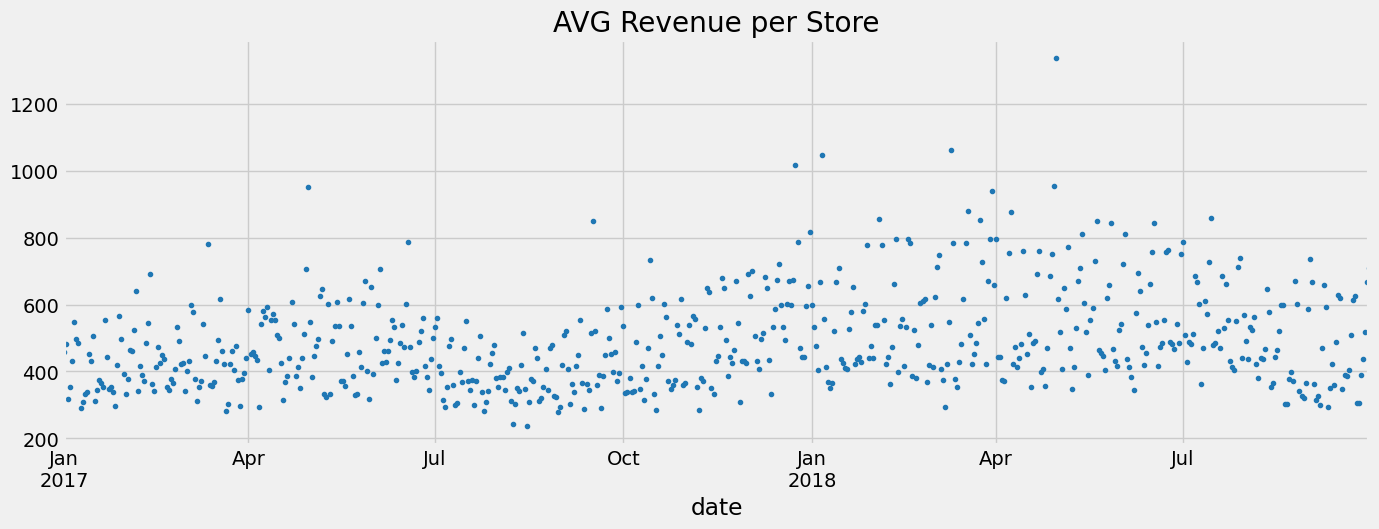

In [8]:
# AVG REVENUE SPREAD.
dataset['avg_revenue'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AVG Revenue per Store')
plt.show()

# DEFINING TRAIN DATA AND TEST DATA

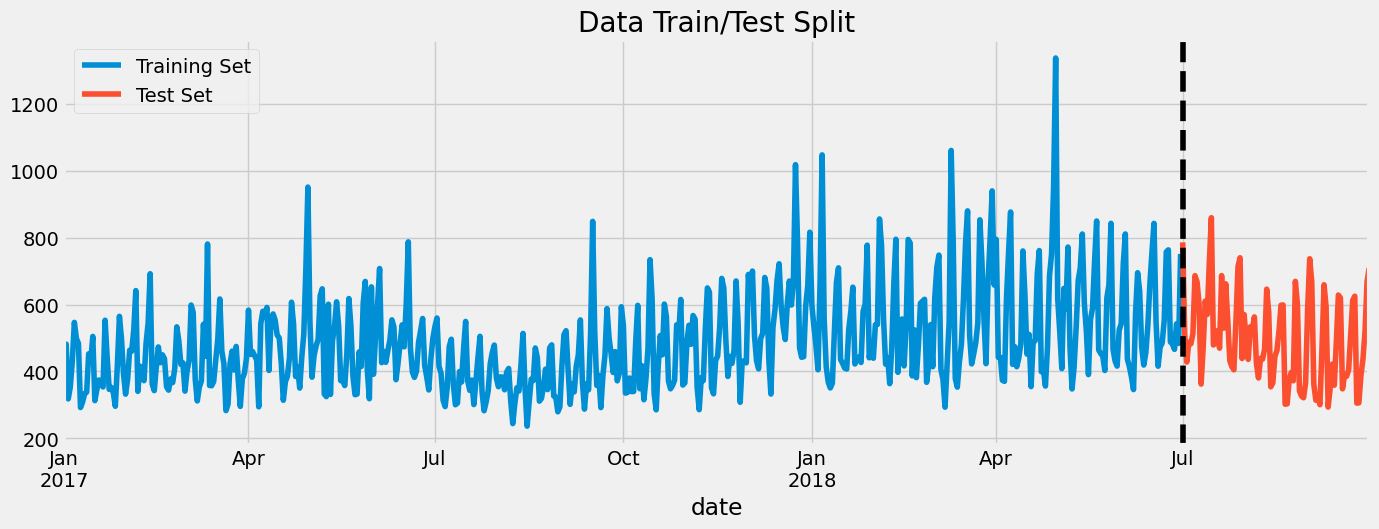

In [9]:
# Create test data and train data.
# Data Train: Jan 2017 - Jun 2018
# Data Test: Jul 2018 - Sept 2018
train = dataset.loc[dataset.index < '07-01-2018']
test = dataset.loc[dataset.index >= '07-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('07-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [10]:
# CREATING FEATURE FOR MODEL
def create_features(dataset):
    """
    Create time series features based on time series index.
    """
    dataset = dataset.copy()
    dataset['dayofweek'] = dataset.index.dayofweek
    dataset['quarter'] = dataset.index.quarter
    dataset['month'] = dataset.index.month
    dataset['year'] = dataset.index.year
    dataset['dayofyear'] = dataset.index.dayofyear
    dataset['dayofmonth'] = dataset.index.day
    dataset['weekofyear'] = dataset.index.isocalendar().week
    return dataset

dataset = create_features(dataset)

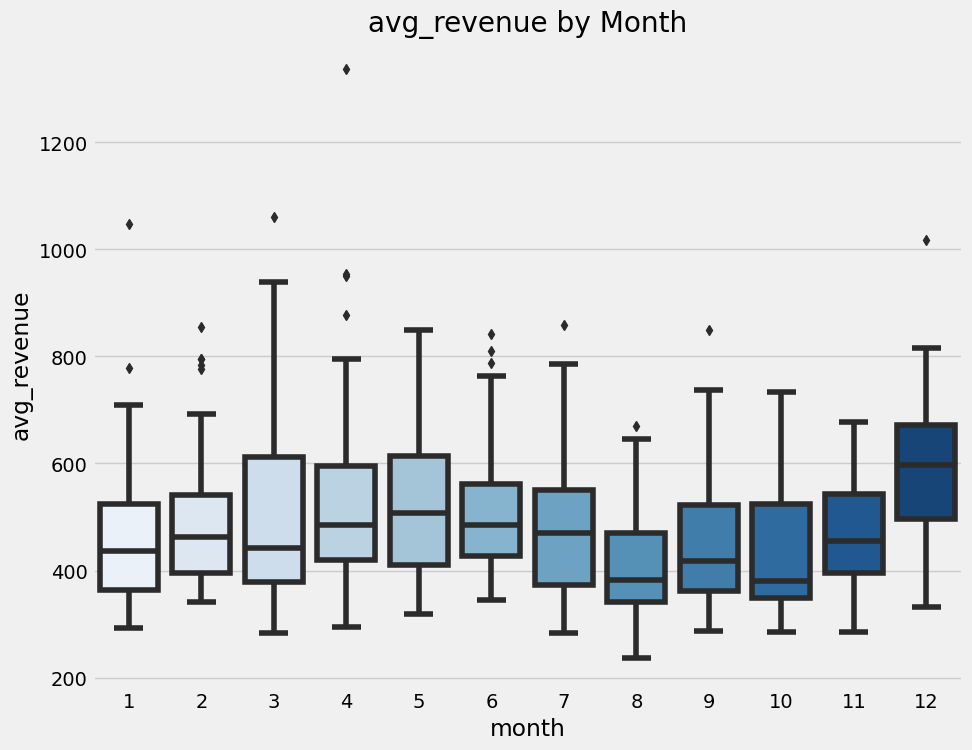

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=dataset, x='month', y='avg_revenue', palette='Blues')
ax.set_title('avg_revenue by Month')
plt.show()

In [12]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'avg_revenue'

# FINALIZATION OF TRAIN DATA AND FEATURES.
X_train = train[FEATURES]
y_train = train[TARGET]

# FINALIZATION OF TEST DATA AND FEATURES.
X_test = test[FEATURES]
y_test = test[TARGET]

# CREATE A MODEL

In [13]:
# RUNNING XGBOOST MODEL
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

# FIT MODEL
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:58:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:504.64724	validation_1-rmse:509.15080
[100]	validation_0-rmse:205.50193	validation_1-rmse:164.69167
[200]	validation_0-rmse:109.91423	validation_1-rmse:83.33114
[300]	validation_0-rmse:85.75655	validation_1-rmse:78.32165
[314]	validation_0-rmse:84.30138	validation_1-rmse:78.65469


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

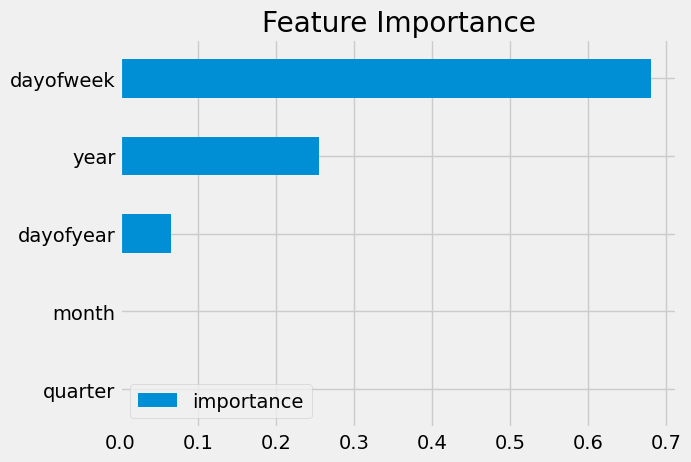

In [14]:
# FEATURE THAT AFFECTS AVG_REVENUE.
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# PREDICT DATA TEST

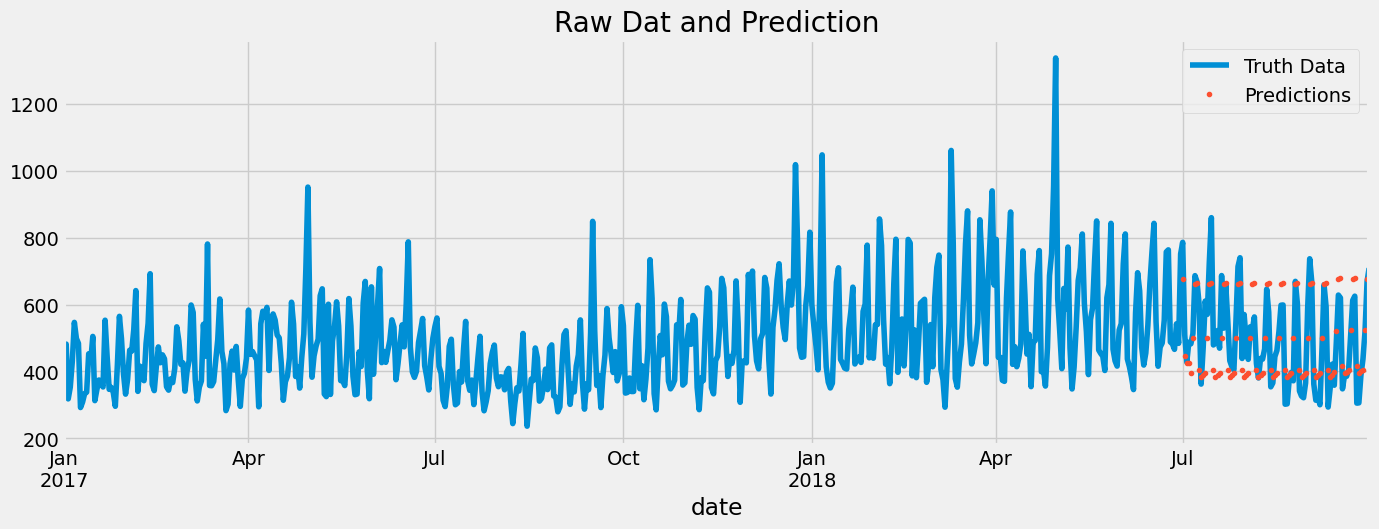

In [15]:
# PREDICT DATA TEST
test['prediction'] = reg.predict(X_test)
dataset = dataset.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = dataset[['avg_revenue']].plot(figsize=(15, 5))
dataset['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

<Axes: xlabel='date'>

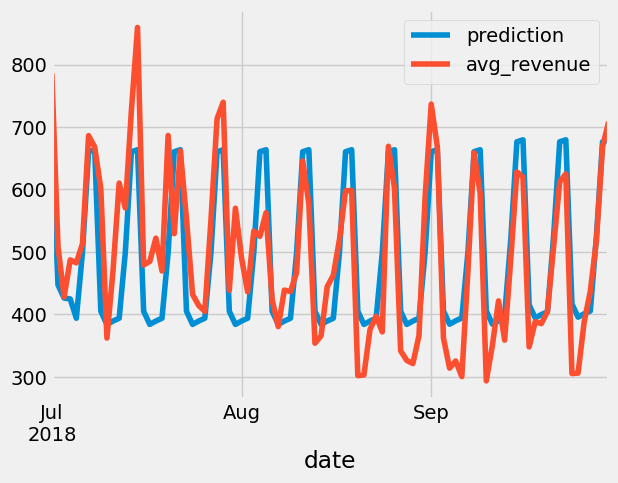

In [16]:
# PREDICTION VS ACTUAL AVG_REVENUE
test['prediction'].plot(legend=True)
test['avg_revenue'].plot(legend=True)

In [17]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
print(f"average error is gonna be roughly {round(mean_absolute_percentage_error(test['avg_revenue'], test['prediction']))}% of the actual value")

average error is gonna be roughly 13% of the actual value


# PREDICT DAILY AVG_REVENUE QUARTER 4 (OCTOBER - DECEMBER)

In [20]:
# Create a date range from start date to end date.
start_date1 = '2018-10-01'
end_date1 = '2018-12-31'
date_range1 = pd.date_range(start=start_date1, end=end_date1)

# Transform it to DataFrame.
df1 = pd.DataFrame({'date': date_range1})
df1 = df1.set_index('date')
df1.index = pd.to_datetime(df1.index)


In [21]:
# Data test
dff = create_features(df1)
dff

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,
2018-10-01,0,4,10,2018,274,1,40
2018-10-02,1,4,10,2018,275,2,40
2018-10-03,2,4,10,2018,276,3,40
2018-10-04,3,4,10,2018,277,4,40
2018-10-05,4,4,10,2018,278,5,40
...,...,...,...,...,...,...,...
2018-12-27,3,4,12,2018,361,27,52
2018-12-28,4,4,12,2018,362,28,52
2018-12-29,5,4,12,2018,363,29,52


In [22]:
# Data Test with the Feature.
df_test = dff[FEATURES]
df_test

,dayofyear,dayofweek,quarter,month,year
date,,,,,
2018-10-01,274,0,4,10,2018
2018-10-02,275,1,4,10,2018
2018-10-03,276,2,4,10,2018
2018-10-04,277,3,4,10,2018
2018-10-05,278,4,4,10,2018
...,...,...,...,...,...
2018-12-27,361,3,4,12,2018
2018-12-28,362,4,4,12,2018
2018-12-29,363,5,4,12,2018


In [23]:
# PREDICT DATA QUARTER 4 WITH MODELS ALREADY CREATED
dff['predict'] = reg.predict(df_test)

In [24]:
dff

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predict
date,,,,,,,,
2018-10-01,0,4,10,2018,274,1,40,416.706116
2018-10-02,1,4,10,2018,275,2,40,395.513641
2018-10-03,2,4,10,2018,276,3,40,400.957458
2018-10-04,3,4,10,2018,277,4,40,405.419647
2018-10-05,4,4,10,2018,278,5,40,524.996033
...,...,...,...,...,...,...,...,...
2018-12-27,3,4,12,2018,361,27,52,433.034729
2018-12-28,4,4,12,2018,362,28,52,549.426270
2018-12-29,5,4,12,2018,363,29,52,677.427551


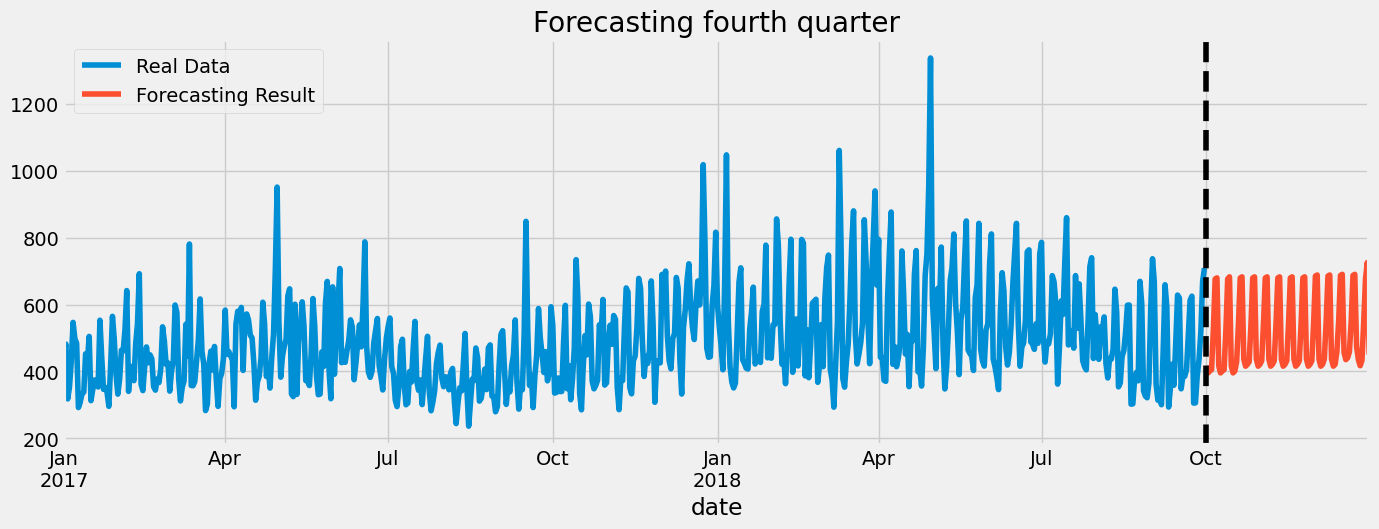

In [25]:
# PLOT PREDICT VS ACTUAL VALUE OF AVG_REVENUE

fig, ax = plt.subplots(figsize=(15, 5))
dataset['avg_revenue'].plot(ax=ax, label='Real Data', title='Forecasting fourth quarter')
dff['predict'].plot(ax=ax, label='Forecasting result')
ax.axvline('10-01-2018', color='black', ls='--')
ax.legend(['Real Data', 'Forecasting Result'])
plt.show()

In [26]:
dff['predict'].describe()

count     92.000000
mean     515.124817
std      114.716942
min      395.513641
25%      421.020142
50%      436.985168
75%      677.942627
max      725.592102
Name: predict, dtype: float64